Cross-Validation Accuracy Scores: [0.625      0.71428571 0.71428571 0.85714286 0.85714286]
Average Cross-Validation Accuracy: 0.7535714285714287
                precision    recall  f1-score   support

  High Traffic       0.75      1.00      0.86         3
   Low Traffic       1.00      1.00      1.00         3
Medium Traffic       1.00      0.67      0.80         3

      accuracy                           0.89         9
     macro avg       0.92      0.89      0.89         9
  weighted avg       0.92      0.89      0.89         9

Prediction Probabilities: [[0.33 0.43 0.24]
 [0.43 0.28 0.29]
 [0.02 0.07 0.91]
 [0.89 0.1  0.01]
 [0.09 0.07 0.84]
 [0.34 0.43 0.23]
 [0.28 0.52 0.2 ]
 [0.59 0.12 0.29]
 [0.84 0.14 0.02]]
Class distribution after SMOTE: {np.int64(0): np.int64(15), np.int64(1): np.int64(15), np.int64(2): np.int64(15)}
Confusion Matrix DataFrame:
                High Traffic  Low Traffic  Medium Traffic
High Traffic               3            0               0
Low Traffic  

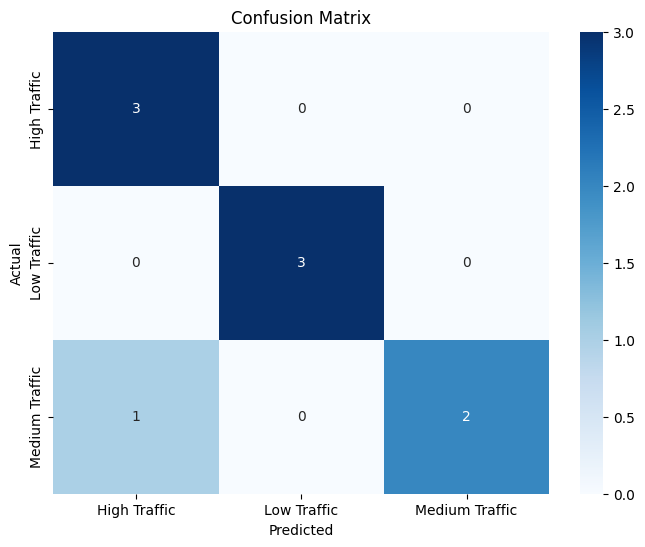

Model and scalers saved.


In [5]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')

# Load and preprocess data
data = pd.read_csv('data/Train.csv')  # Ensure file exists and columns match
data = data.sort_values(by=['date_time'], ascending=True).reset_index(drop=True)

# Feature Engineering
last_n_hours = [1, 2, 3, 4, 5, 6]
for n in last_n_hours:
    data[f'last_{n}_hour_traffic'] = data['traffic_volume'].shift(n)
data = data.dropna().reset_index(drop=True)

# Binary encoding of holidays
data['is_holiday'] = data['is_holiday'].apply(lambda x: 1 if x != 'None' else 0)
data['date_time'] = pd.to_datetime(data['date_time'])
data['hour'] = data['date_time'].dt.hour
data['month_day'] = data['date_time'].dt.day
data['day'] = data['date_time'].dt.weekday + 1  # Corrected weekday attribute
data['month'] = data['date_time'].dt.month
data['year'] = data['date_time'].dt.year

# Define traffic categories based on new thresholds
percentiles = data['traffic_volume'].quantile([0.33, 0.66]).to_dict()
low_threshold = percentiles[0.33]
high_threshold = percentiles[0.66]

def categorize_traffic(volume):
    if volume == 0:
        return 'No Traffic'
    elif volume <= low_threshold:
        return 'Low Traffic'
    elif volume <= high_threshold:
        return 'Medium Traffic'
    else:
        return 'High Traffic'

data['traffic_category'] = data['traffic_volume'].apply(categorize_traffic)

# Prepare dataset
features = ['is_holiday', 'temperature', 'day', 'hour', 'month_day', 'year', 'month']  # Ensure all columns are in the dataset
X = data[features]
y = data['traffic_category']

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Scale features
x_scaler = MinMaxScaler()
X = x_scaler.fit_transform(X)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define model and cross-validation strategy
model = RandomForestClassifier(random_state=1, class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Average Cross-Validation Accuracy: {cv_scores.mean()}')

# Define and train the model with GridSearchCV for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Evaluate the model on test data
y_pred_test = best_model.predict(X_test)
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

# Check prediction probabilities
prediction_probs = best_model.predict_proba(X_test)
print(f'Prediction Probabilities: {prediction_probs}')

# Check class distribution after SMOTE
unique, counts = np.unique(y, return_counts=True)
print(f'Class distribution after SMOTE: {dict(zip(unique, counts))}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
print(f'Confusion Matrix DataFrame:\n{cm_df}')

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model and scalers
joblib.dump(best_model, 'bugmodel.pkl')
joblib.dump(x_scaler, 'bugscalers.pkl')
joblib.dump(label_encoder, 'bugencoders.pkl')
print("Model and scalers saved.")


Random Forest Accuracy: 0.7214
Gradient Boosting Accuracy: 0.7214
XGBoost Accuracy: 0.7214
Support Vector Classifier Accuracy: 0.5464
                precision    recall  f1-score   support

  High Traffic       0.75      1.00      0.86         3
   Low Traffic       1.00      1.00      1.00         3
Medium Traffic       1.00      0.67      0.80         3

      accuracy                           0.89         9
     macro avg       0.92      0.89      0.89         9
  weighted avg       0.92      0.89      0.89         9

Prediction Probabilities: [[0.34 0.41 0.25]
 [0.35 0.33 0.32]
 [0.04 0.09 0.87]
 [0.93 0.03 0.04]
 [0.03 0.04 0.93]]
Confusion Matrix DataFrame:
                High Traffic  Low Traffic  Medium Traffic
High Traffic               3            0               0
Low Traffic                0            3               0
Medium Traffic             1            0               2


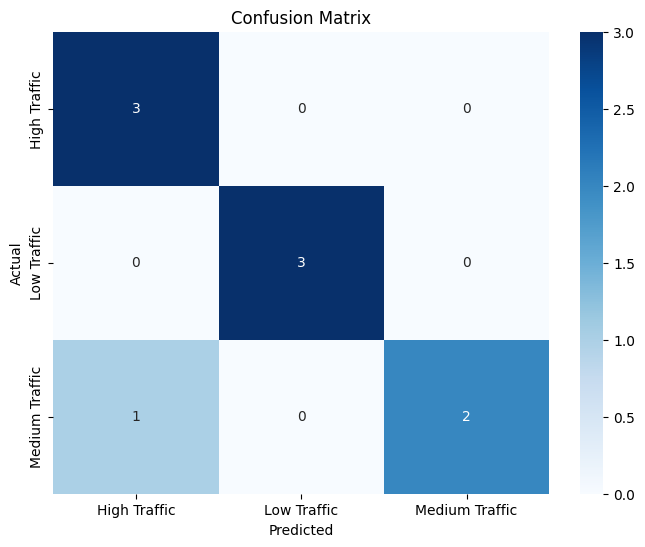

       feature  importance
3    month_day    0.357114
1  temperature    0.249338
5        month    0.199306
4         year    0.105298
2          day    0.088945
0   is_holiday    0.000000
6     hour_sin    0.000000
7     hour_cos    0.000000


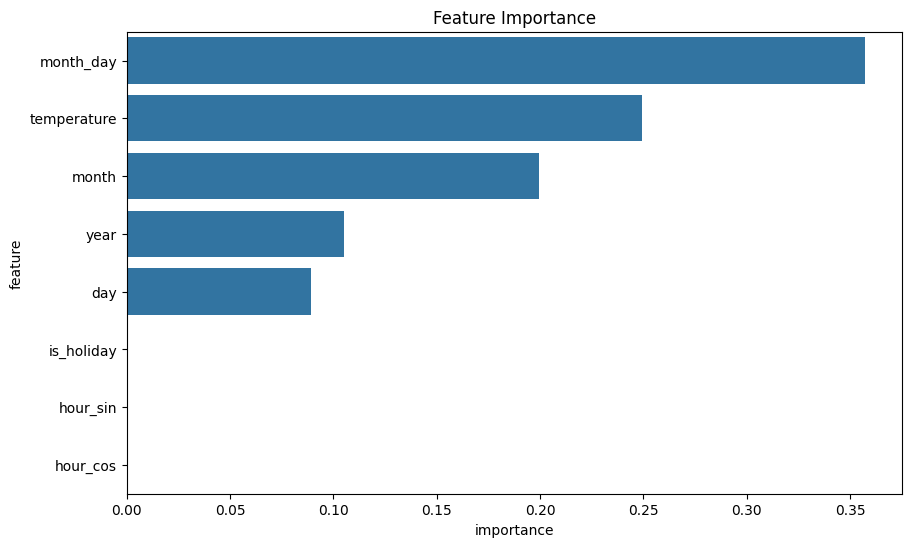

Model, scaler, and label encoder saved.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings

warnings.filterwarnings('ignore')

# Load and preprocess data
data = pd.read_csv('data/Train.csv')  # Ensure the file exists and columns match
data = data.sort_values(by=['date_time'], ascending=True).reset_index(drop=True)

# Feature Engineering - Adding traffic data from previous hours
last_n_hours = [1, 2, 3, 4, 5, 6]
for n in last_n_hours:
    data[f'last_{n}_hour_traffic'] = data['traffic_volume'].shift(n)
data = data.dropna().reset_index(drop=True)

# Binary encoding of holidays
data['is_holiday'] = data['is_holiday'].apply(lambda x: 1 if x != 'None' else 0)
data['date_time'] = pd.to_datetime(data['date_time'])
data['hour'] = data['date_time'].dt.hour
data['month_day'] = data['date_time'].dt.day
data['day'] = data['date_time'].dt.weekday + 1
data['month'] = data['date_time'].dt.month
data['year'] = data['date_time'].dt.year

# Add cyclical encoding for hour
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

# Define traffic categories based on new thresholds
percentiles = data['traffic_volume'].quantile([0.33, 0.66]).to_dict()
low_threshold = percentiles[0.33]
high_threshold = percentiles[0.66]

def categorize_traffic(volume):
    if volume == 0:
        return 'No Traffic'
    elif volume <= low_threshold:
        return 'Low Traffic'
    elif volume <= high_threshold:
        return 'Medium Traffic'
    else:
        return 'High Traffic'

data['traffic_category'] = data['traffic_volume'].apply(categorize_traffic)

# Prepare dataset
features = ['is_holiday', 'temperature', 'day', 'month_day', 'year', 'month', 'hour_sin', 'hour_cos']  # Updated features
X = data[features]
y = data['traffic_category']

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Scale features
x_scaler = MinMaxScaler()
X = x_scaler.fit_transform(X)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define and compare multiple models
models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False),
    'Support Vector Classifier': SVC(random_state=42, probability=True)
}

# Perform cross-validation and print accuracy for each model
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f'{model_name} Accuracy: {cv_scores.mean():.4f}')

# Use RandomizedSearchCV for hyperparameter tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomForest and search for best hyperparameters
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
random_search = RandomizedSearchCV(rf_model, param_grid_rf, n_iter=10, cv=cv, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

# Evaluate the best model on test data
y_pred_test = best_model.predict(X_test)
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

# Check prediction probabilities
prediction_probs = best_model.predict_proba(X_test)
print(f'Prediction Probabilities: {prediction_probs[:5]}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
print(f'Confusion Matrix DataFrame:\n{cm_df}')

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance for Random Forest
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

# Save the model and encoders
joblib.dump(best_model, 'traffic_prediction_model.pkl')
joblib.dump(x_scaler, 'traffic_scaler.pkl')
joblib.dump(label_encoder, 'traffic_label_encoder.pkl')
print("Model, scaler, and label encoder saved.")
